In [1]:
!git lfs install
!pip install transformers

!GIT_LFS_SKIP_SMUDGE=1

Git LFS initialized.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
'GIT_LFS_SKIP_SMUDGE' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [3]:
num_questions = 0

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
def get_data(questions, context, answers, spans):
    """
    Read raw text from files and convert into lists.
    """
    with open(questions, encoding='utf-8') as f:
        raw_questions = f.read().splitlines()

    with open(context, encoding='utf-8') as f:
        raw_context = f.read().splitlines()

    with open(answers, encoding='utf-8') as f:
        raw_answers = f.read().splitlines()

    with open(spans, encoding='utf-8') as f:
        raw_spans = f.read().splitlines()

    """
    answer = {'text': ..., 'answer_start': ..., 'answer_end': ...}
    """
    Answers = []
    for iter in range(len(raw_answers)):
        dic = {}
        dic['text'] = raw_answers[iter]
        # Add any additional processing logic here if needed
        Answers.append(dic)

    # Combine context, questions, and answers
    combined_data = list(zip(raw_context, raw_questions, Answers))

    # Split into training and validation sets (80-20 split)
    train_data, val_data = train_test_split(combined_data, test_size=0.2, random_state=42)

    # Unpack the split data
    train_context, train_questions, train_answers = zip(*train_data)
    val_context, val_questions, val_answers = zip(*val_data)

    return train_context, train_questions, train_answers, val_context, val_questions, val_answers


In [5]:
train_context, train_questions, train_answers, val_context, val_questions, val_answers = get_data(
    "real_que_tel.txt",
    "real_con_tel.txt",
    "real_ans_tel.txt",
    "real_span_tel.txt"
)

In [6]:
print(f"Train_Context : {train_context[1]}")
print(f"Train_Question : {train_questions[1]}")
print(f"Train_Answer: {train_answers[1]}")

print(f"Val_Context : {val_context[0]}")
print(f"Val_Question : {val_questions[0]}")
print(f"Val_Answer: {val_answers[0]}")



Train_Context : తనిఖీ సేవ క్వాలిఫైడ్ ఎలివేటర్ మెకానిక్స్ ద్వారా తనిఖీ మరియు నిర్వహణ ప్రయోజనాల కోసం పైకి మరియు కారు టాప్ యాక్సెస్ చేయడానికి రూపొందించబడింది. ఇది మొదటిసారి 'తనిఖీ', 'కారు టాప్', 'ఆక్సెస్ ఎనేబుల్' లేదా 'హేవనాబ్' అని పిలిచే కార్ ఆపరేటింగ్ ప్యానెల్లో కీ స్విచ్చే సక్రియం చేయబడుతుంది. ఈ స్విచ్ సక్రియం చేయబడినప్పుడు ఎలివేటర్ కదిలితే, ఆపడానికి వదలడం వలన, కారు కాల్స్ రద్దు చేయబడతాయి (మరియు బటన్లు నిలిపివేయబడతాయి), మరియు హాల్ కాల్లు ఇతర ఎలివేటర్ కార్లకు సమూహంలో కేటాయించబడతాయి (లేదా ఒకే ఎలివేటర్ కాన్ఫిగరేషన్లో రద్దు చేయబడతాయి). ఎలివేటర్ ఇప్పుడు కేవలం 'యాక్సెస్' కీ స్విచ్లు ద్వారా మాత్రమే తరలించబడుతుంటాయి, సాధారణంగా అత్యధికంగా (కారు పైభాగంలోకి చేరుకోవడం) మరియు అత్యల్ప (ఎలివేటర్ గొయ్యిని యాక్సెస్ చేయడానికి) లాండింగ్లు. యాక్సెస్ కీ స్విచ్లు కారు హాయిస్వే తలుపు తెరిచినప్పుడు తక్కువ తనిఖీ వేగంతో తరలించడానికి అనుమతిస్తుంది. ఈ వేగం అత్యంత నియంత్రికల మీద సాధారణ ఆపరేటింగ్ వేగం యొక్క ఎక్కడైనా 60% వరకు ఉంటుంది మరియు సాధారణంగా స్థానిక భద్రతా సంకేతాలు ద్వారా నిర్వచించబడతాయి.
Train_Question : స్

613


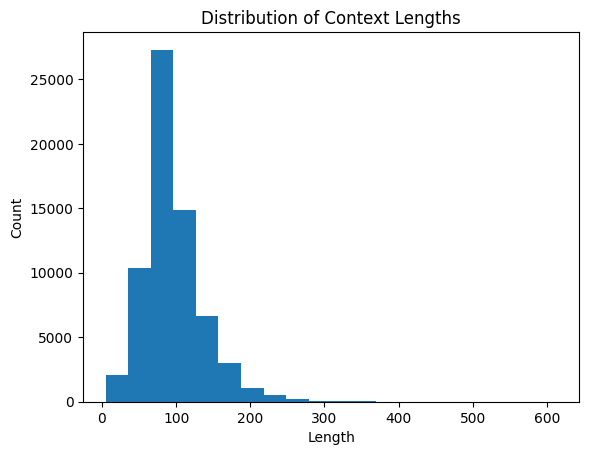

In [7]:
token_lens = []

for txt in train_context:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

In [8]:
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

35
66084


In [9]:
MAX_LENGTH = 300

In [26]:
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM,  AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [27]:
tokenizer.is_fast

True

In [28]:
train_encodings = tokenizer(train_questions, train_context,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings = tokenizer(val_questions, val_context,  max_length = MAX_LENGTH, truncation=True, padding = True)

In [29]:
type(train_encodings)

transformers.tokenization_utils_base.BatchEncoding

In [30]:
print(train_encodings.keys())
print(valid_encodings.keys())
print(len(train_encodings['input_ids']))
print(len(train_encodings['input_ids'][0]))


dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask'])
66084
300


In [31]:
print(train_encodings['input_ids'][1])

[0, 16755, 5271, 43162, 8653, 229021, 1092, 65373, 43009, 169680, 55442, 48125, 164643, 32, 2, 2, 10675, 2538, 25321, 15312, 72347, 35554, 2502, 16489, 196294, 6580, 8576, 6108, 18772, 30266, 18793, 9465, 1789, 44272, 29446, 10675, 2538, 25321, 15312, 11527, 217503, 200838, 13367, 16078, 2584, 11527, 116102, 103463, 57676, 3421, 175947, 138354, 213400, 146126, 5, 19588, 55442, 44674, 242, 3289, 1789, 25321, 15312, 25, 4, 242, 2635, 4873, 103463, 25, 4, 242, 37803, 3421, 175947, 8576, 4963, 138400, 25, 39165, 242, 152234, 2502, 6975, 18067, 25, 7749, 21969, 6108, 26283, 52582, 138378, 16783, 56952, 177085, 49468, 16351, 6, 18783, 16755, 5271, 165970, 8653, 229021, 1092, 13973, 94219, 32396, 5, 1767, 16755, 5271, 43162, 8653, 229021, 1092, 13973, 145135, 43009, 8576, 6108, 18772, 30266, 5336, 6204, 1944, 64653, 4, 138378, 22655, 8729, 107568, 11055, 114723, 4, 116102, 124100, 1886, 179308, 13973, 94219, 147174, 15, 3071, 3991, 18515, 8703, 145550, 1361, 6254, 6108, 15101, 18772, 4230, 94

In [32]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding = tokenizer(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings['input_ids'][idx]) -  len(answer_encoding['input_ids']) ): #len(train_encodings['input_ids'][0])):
        match = True
        iter = 0
        for i in range(1,len(answer_encoding['input_ids']) - 1):
            iter =i
            if (answer_encoding['input_ids'][i] != train_encodings['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+iter+1
            break
    return(ret_start, ret_end)

In [33]:
test_rec=48

z,x = ret_Answer_start_and_end_train(test_rec)
print(z, x)

predict_answer_tokens = train_encodings.input_ids[test_rec][z : x]
print(tokenizer.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizer.decode(train_encodings['input_ids'][test_rec]))

224 226
18 వ
 18 వ
<s> ఏ శతాబ్దం నుంచి ఆధునిక రాజకీయ ప్రక్రియలు రాయల్ సొసైటీని మరచిపోయాయి?</s></s> రాజ్యసంబంధమైన రాజ్యం అనేది ఒక దేశం యొక్క రాజ్యాంగ రాజు ( బహుశా ఒక ప్రాతినిధ్య అధికారి ద్వారా ) అధికారికంగా ఆ దేశం యొక్క పార్లమెంట్ చర్యను ఆమోదిస్తుంది, తద్వారా ఇది ఒక చట్టం లేదా చట్టంగా ప్రకటించబడుతోంది. చాలా సమకాలీన సమకాలీన రాచరికాలలో, ఈ చర్యను ఒక సాంప్రదాయం కంటే కొంచం ఎక్కువగా పరిగణించారు ; రాజ్యసంబంధమైన ( యునైటెడ్ కింగ్డమ్, నార్వే మరియు లిక్టెస్టీన్ వంటివి ) నిరాకరించడానికి వారి పాలకుడు ఇప్పటికీ అనుమతించే ఆ దేశాల్లో కూడా చక్రవర్తి దాదాపు ఎప్పుడూ అలా చేయలేదు, అత్యవసర రాజకీయ అత్యవసర పరిస్థితిలో లేదా వారి ప్రభుత్వానికి సలహా ఇచ్చేవాడు. రాజ్యసంబంధమైన అనుమతిని నిలిపివేసే అధికారం ఒకసారి యూరోపియన్ రాచరికాలలో తరచుగా ఉపయోగించబడింది, ఇది 18 వ శతాబ్దం నుంచి అక్కడ అభివృద్ధి చెందిన ఆధునిక, ప్రజాస్వామ్య రాజకీయ వాతావరణంలో చాలా అరుదు.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [34]:
print(train_encodings.keys())
print(valid_encodings.keys())
print(len(train_encodings['input_ids']))

dict_keys(['input_ids', 'attention_mask'])
dict_keys(['input_ids', 'attention_mask'])
66084


In [35]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings['input_ids'])):
    #print(h)
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

10697


In [36]:
print(train_encodings.keys())
print(valid_encodings.keys())
print(len(train_encodings['input_ids']))

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'attention_mask'])
66084


In [43]:
test_rec = 2
print(train_encodings['start_positions'][test_rec])
print(train_encodings['end_positions'][test_rec])
predict_answer_tokens = train_encodings.input_ids[test_rec][train_encodings['start_positions'][test_rec] : train_encodings['end_positions'][test_rec]]
print(tokenizer.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizer.decode(train_encodings['input_ids'][test_rec]))

157
160
అనుభవవాదం
 అనుభవవాదం
<s> అరిస్టాటిల్ ఏ సిద్ధాంతాన్ని ప్రవేశపెట్టారు?</s></s> తత్ఫలితంగా, ప్లాటో మరియు అరిస్టాటిల్ సహజ సిద్ధాంతం యొక్క మొదటి క్రమబద్ధమైన చర్చలను ఉత్పత్తి చేశాయి, ఇది ప్రకృతి యొక్క తరువాత పరిశోధనలు రూపొందించడానికి చాలా చేసింది. ఖచ్చితమైన తర్కం యొక్క అభివృద్ధి అనేది తరువాత శాస్త్రీయ విచారణకు ప్రత్యేక ప్రాముఖ్యత మరియు ఉపయోగం. ప్లేటో 387 bc లో ప్లాటోనిక్ అకాడమీని స్థాపించింది, దీని నినాదం " జ్యామితిలో ఎవరూ ప్రవేశించకుండా ఉండనివ్వండి ", మరియు అనేక ప్రముఖ తత్వవేత్తలు మారినది. ప్లాటో యొక్క విద్యార్ధి అరిస్టాటిల్ అనుభవవాదం మరియు సార్వత్రిక సత్యాలను పరిశీలన మరియు ప్రేరేపణ ద్వారా చేరుకోవచ్చనే భావనను ప్రవేశపెట్టారు, తద్వారా శాస్త్రీయ పద్ధతి యొక్క పునాదులు వేసాయి. అరిస్టాటిల్ అనేక జీవశాస్త్ర రచనలను ప్రకృతిలో అనుభావికమైనది, ఇది జీవసంబంధ కారణము మరియు జీవవైవిధ్యం మీద దృష్టి పెట్టింది. అతను ప్రకృతి యొక్క లెక్కలేనన్ని పరిశీలనలను చేశాడు, ముఖ్యంగా అతని చుట్టూ ఉన్న ప్రపంచంలోని మొక్కలు మరియు జంతువుల అలవాట్లు మరియు లక్షణాలు, 540 కంటే ఎక్కువ జంతు జాతులు వర్గీకరించబడ్డాయి మరియు కనీసం 50

In [44]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding = tokenizer(val_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings['input_ids'][idx])  -  len(answer_encoding['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        iter = 0
        for i in range(1,len(answer_encoding['input_ids']) - 1):
            iter = i
            if (answer_encoding['input_ids'][i] != valid_encodings['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+iter+1
            break
    return(ret_start, ret_end)

In [45]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings['input_ids']) ):
    #print(h)
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


valid_encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

2668


In [46]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings.input_ids[test_rec][z : x]
print(tokenizer.decode(predict_answer_tokens))
print(val_answers[test_rec]['text'])
print(tokenizer.decode(valid_encodings['input_ids'][test_rec]))

కేంద్రీయ
కేంద్రీయ
<s> ఏ ప్రామాణిక ప్రామాణిక ఉచ్చారణను కలిగి ఉంటుంది?</s></s> కేంద్రీయ భాష ప్రామాణిక భాషగా భావించబడుతుంది మరియు అత్యధిక సంఖ్యలో మాట్లాడేవారు ఉన్నారు. ఇది బార్సిలోనా ప్రావిన్స్ యొక్క జనసాంద్రత కలిగిన ప్రాంతాలలో, తారగానో ప్రావిన్సు యొక్క తూర్పు భాగంలో మరియు గిరోనా ప్రావిన్సులో చాలా ప్రాంతాలలో మాట్లాడబడుతుంది.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [47]:
print(train_encodings.keys())
print(valid_encodings.keys())
print(len(train_encodings['input_ids']))
print(len(train_encodings['start_positions']))
print(len(train_encodings['end_positions']))
print(len(valid_encodings['input_ids']))
print(len(valid_encodings['start_positions']))
print(len(valid_encodings['end_positions']))

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
66084
66084
66084
16521
16521
16521


In [64]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [65]:
train_dataset = InputDataset(train_encodings)
valid_dataset = InputDataset(valid_encodings)

In [66]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

In [ ]:
# !git clone git://huggingface.co/ai4bharat/indic-bert.git

In [ ]:
# MODEL_PATH = '/working/indic-bert'

In [51]:
bert_model = AutoModelForMaskedLM.from_pretrained("FacebookAI/xlm-roberta-base")
# bert_model = BertModel.from_pretrained(MODEL_PATH)  #MODEL_PATH = "bert-base-uncased"

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model.roberta  # Access the RoBERTa model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def forward(self, input_ids, attention_mask):
        model_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = model_output.hidden_states
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)  # Concatenate last and third-to-last layers
        logits = self.linear_relu_stack(out)

        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
model = QAModel()

In [53]:
bert_model

XLMRobertaForMaskedLM(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
  

In [54]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [55]:
if torch.cuda.is_available():
    # Get the name of the GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name with CUDA: {gpu_name}")

GPU name with CUDA: Tesla P100-PCIE-16GB


In [56]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [57]:
def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

    #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end

    #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)

    nll = nn.NLLLoss()

    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

    #return mean of the Loss for the start and end logits
    return ((fl_start + fl_end)/2)

In [58]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [59]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask)
        #loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1) #using gamma = 1
        losses.append(loss.item())
        loss.backward()
        optim.step()
        
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
            
        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        #ctr = ctr +1
        #if ctr==50:
        #    break
        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [60]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            
            out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask)
            
            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)
            
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            #ctr = ctr +1
            #if ctr==50:
            #    break
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
        #ret_loss = sum(losses)/len(losses)
    return(ret_acc)

In [67]:
EPOCHS = 3

model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

torch.save(model.state_dict(), "QA_finutunemodel.pt")

Running Epoch : 100%|██████████| 4131/4131 [36:05<00:00,  1.91it/s]


Train Accuracy: 0.430540426046962      Train Loss: 2.0510933724998766


Running Evaluation: 100%|██████████| 517/517 [02:47<00:00,  3.09it/s]


Validation Accuracy: 0.5222907264354842


Running Epoch : 100%|██████████| 4131/4131 [36:01<00:00,  1.91it/s]


Train Accuracy: 0.5410085330428468      Train Loss: 1.5191449244211095


Running Evaluation: 100%|██████████| 517/517 [02:46<00:00,  3.10it/s]


Validation Accuracy: 0.5455183484222257


Running Epoch : 100%|██████████| 4131/4131 [36:02<00:00,  1.91it/s]


Train Accuracy: 0.5969423263132414      Train Loss: 1.274948233937386


Running Evaluation: 100%|██████████| 517/517 [02:46<00:00,  3.10it/s]


Validation Accuracy: 0.553047093305182


In [ ]:
EPOCHS = 2

model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")

torch.save(model.state_dict(), "QA_finutunemodel.pt")

In [75]:
def get_answer(question, context):
    # Tokenize the input question and context
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt', max_length=512, truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get model predictions
    with torch.no_grad():
        output_start, output_end = model(input_ids=input_ids, 
                attention_mask=attention_mask)
        
        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        # Convert token IDs to string
        answer_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][answer_start:answer_end])
        answer = tokenizer.convert_tokens_to_string(answer_tokens)

    return answer

In [76]:


def compute_f1score(sentence1, sentence2):
    # Convert the sentences to sets of characters
    set1 = set(sentence1)
    set2 = set(sentence2)

    # Calculate the intersection and union of characters
    common_chars = set1.intersection(set2)
    all_chars = set1.union(set2)

    # Compute precision, recall, and F1 score
    precision = len(common_chars) / len(all_chars) if len(all_chars) > 0 else 0
    recall = len(common_chars) / len(set1) if len(set1) > 0 else 0

    # Avoid division by zero for precision and recall
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return f1_score

In [77]:
def exact_match(string1 , string2):
  ## remove the space characters

  string1 = string1.replace(" ","")
  string2 = string2.replace(" ","")

  ## length check

  if(len(string1) != len(string2)):
    return 0

  ## every char check
  length = len(string1)

  for iter in range(length):
    if(string1[iter] != string2[iter]):
      return 0

  return 1

In [78]:
answers = []
for iter in range(len(val_context)):
    ans = get_answer(val_questions[iter] , val_context[iter])
    answers.append(ans)

In [79]:
print(answers)

['సాధారణ కార్బోహైడ్రేట్లు', '1456', 'కేంద్రీయ భాష', 'కనీసం మూడు సెట్ల కోతలు', 'అంతర్జాతీయ క్రిమినల్ కోర్టు', '25 మీటర్ల', 'రాబర్ట్ మక్నార', '50 %', '', 'అమ్నెస్టీ ఇంటర్నేషనల్', 'తొమ్మిది', 'సెమ్ స్మిత్', 'హరికేన్ ఐక్', 'ఫ్లాట్హెడ్ సరస్సుతో', 'సంపూర్ణ గొప్ప', '25', 'సర్క్యూట్లో విద్యుత్ నిరోధకత', '$ 2-3bn', 'ఆడమ్ మికివిక్జ్', '89.38 %', 'ఖరిజైట్స్', 'రాజు ఎడ్వర్డ్ vii', 'హైదరాబాదు మెట్రోపాలిటన్ డెవలప్మెంట్ అథారిటీ', '', 'కోయలీ లా స్కూల్ పాఠశాలలో', 'అట్లాంటిక్ సిటీ రెగ్యులేటరీ సంస్కరణ గోవి', '', 'విద్యుదయస్కాంత', 'రోమన్ కాథలిక్ మరియు ప్రొటెస్టంట్ సంస్కరణలు', 'అపోలో మరియు గాయాలు', '19 %', '3 అంగుళాలు', '148.636', '', 'జీర్ణరహిత రసాలు', 'సముద్రం మరియు వర్తకం', 'అక్కాడియన్', 'ట్రాఫిక్ సర్క్యూట్', '13.5 గంటలు', '125', 'ప్రోగ్రెసివ్ ఎథిక్స్ వాచ్ డాగ్ గ్రూప్', 'ఉత్తరాది అమెరికన్', '1973', 'పశ్చిమాన బహుభార్యాత్వం యొక్క నూతన సాంకేతికత', '', '860 bc', '', 'ఒక సాహిత్య పరికరం', 'మూడు', 'వివిధ రకాల సేంద్రీయ సమ్మేళనాలను దిగజార్చే బ్యాక్టీరియా సామర్థ్యం', '', '600', '', 'మేయర్-కౌన్సిల్', '$ 26,969', '

In [80]:
print(val_answers)

({'text': ' సాధారణ కార్బోహైడ్రేట్లు'}, {'text': ' 1391'}, {'text': 'కేంద్రీయ'}, {'text': ' మూడు'}, {'text': ' అంతర్జాతీయ క్రిమినల్ కోర్టు యొక్క ప్రాసిక్యూటర్కు'}, {'text': ' 25 మీటర్ల ( 82 అడుగులు )'}, {'text': ' రాబర్ట్ మక్నార'}, {'text': ' 50 %'}, {'text': '. ఎలెక్ట్రాన్ ఎనర్జీ స్థాయి పరివర్తనాలు ఉపయోగించబడే జాగ్రత్తగా ఎంపిక చేసుకోవడం ద్వారా , మరియు వర్ణపట పంపిణీని సవరించే ఫ్లోరోసెంట్'}, {'text': ' అమ్నెస్టీ ఇంటర్నేషనల్'}, {'text': ' తొమ్మిది'}, {'text': ' డెమో'}, {'text': 'హరికేన్ ఐక్'}, {'text': ' ఫ్లాట్హెడ్ సరస్సుతో'}, {'text': ' సంపూర్ణ గొప్ప'}, {'text': ' 65'}, {'text': ' విద్యుత్ నిరోధకత'}, {'text': ' $ 2-3bn'}, {'text': 'ఆడమ్ మికివిక్జ్'}, {'text': ' 89.38 %'}, {'text': ' ఖరిజైట్స్ '}, {'text': 'రాజు ఎడ్వర్డ్ vii'}, {'text': ' పట్టణ ప్రణాళికా'}, {'text': 'ఇంపీరియల్ కాలేజీ లండన్'}, {'text': 'తరలించబడింది . కోయలీ లా స్కూల్'}, {'text': ' పురాతన కారు'}, {'text': 'విరాళాల శాతం ఏమిటో నిర్ణయించే బోర్డు సభ్యులందరూ వారి వ్యక్తిగత సంపదను పెంచుతుంటారు , ఇవి ఒక ఎన్పో యొక్క హోదాను దుర్విని

In [7]:
print(val_questions)

('సాంప్రదాయకంగా వేగంగా రక్తనాళాల గ్లూకోజ్ స్థాయిలు పెరగడంతో శోషించబడిందని నమ్మకం ఏమిటి ?', 'యూదుల విభాగం ఎప్పుడు దాడికి గురైంది ?', 'ఏ ప్రామాణిక ప్రామాణిక ఉచ్చారణను కలిగి ఉంటుంది?', 'హాలీవుడ్కు ముందు ఎంత రౌండ్లు పోటీ పడుతున్నాయి ?', 'భద్రతా మండలి అధికారికంగా డార్ఫుర్లో పరిస్థితిని ఎవరికి అప్పగించింది ?', 'ఎంత దూరం రన్ అవుతుందో ?', '1968 లో ప్రపంచ బ్యాంక్ అధ్యక్షుడు ఎవరు ?', 'మలేరియా మరణం యొక్క ప్రమాదం ఒక ఉభయ హైవ్ సంక్రమణ ఎంత ద్వారా పెరుగుతుంది ?', 'కాంతి ప్రకాశించే కాంతి సంచారాల రూపాన్ని ఎలా పోలివుంటుంది?', 'జనవరి 1977 లో జరిగిన విద్యార్థుల మరియు సైనిక అధికారుల రాజకీయ అమలును ఎవరు విమర్శించారు ?', 'ఇమెయిల్ పొరపాటు మొదట ఎన్ని ఉద్దేశించిన విద్యార్థుల కోసం ఉద్దేశించబడింది ?', 'ఈ థీమ్ యొక్క వాస్తవ చిత్రం వాస్తవ చిత్రంలో ఉపయోగించబడింది ?', 'ఏ ఇతర హరికేన్తో బేయోన్స్ ఫౌండేషన్ సహాయం చేసింది?', 'పాశ్చాత్య యునైటెడ్ స్టేట్స్ లో అతిపెద్ద మంచినీటి సరస్సు పేరు ఏమిటి ?', 'పాల్ రాడ్గర్స్ నుండి విడిపోయిన తర్వాత విడుదలైన అతి పెద్ద హిట్ సంకలనం రాణి పేరు ఏమిటి ?', 'ఇరాన్లో 1960 ల చివరినాటికి ఎన్ని వాణిజ్య 

In [13]:
print(val_context[1])

నగరం పద్నాలుగో శతాబ్దం మధ్యలో తీవ్రమైన సమస్యల ద్వారా వెళ్ళింది. ఒక వైపున 1348 యొక్క నల్ల మరణం మరియు తరువాతి సంవత్సరాల్లో అంటురోగాల ద్వారా ప్రజల యొక్క శిధిలమయ్యాయి - మరియు మరొకదానిపై , యుద్ధాల సిరీస్ మరియు తరువాత జరిగిన అల్లర్లు. వీరిలో యూనియన్ యొక్క యుద్ధం , సామ్రాజ్య రాజధానిగా వాలెన్సియా నేతృత్వంలో రాచరికం యొక్క అతిక్రమణకు వ్యతిరేకంగా ఒక పౌరుడు తిరుగుబాటు - మరియు 1363 లో కరేలియన్ దాడులను అడ్డుకోవాలనే కొత్త గోడను ఆగ్రహానికి పెంచడంతో , మరియు 1364. ఈ సంవత్సరాల్లో నగర-క్రైస్తవుని , యూదు మరియు ముస్లింను ఆక్రమించిన మూడు వర్గాల సహజీవనం చాలా వివాదాస్పదంగా ఉంది. వాటర్ఫ్రంట్ చుట్టూ ఉన్న ప్రాంతాన్ని ఆక్రమించిన యూదులకు ఆర్ధికపరంగా మరియు సామాజికంగా అభివృద్ధి చెందింది మరియు వారి త్రైమాసికంలో పొరుగు పారిష్ల వ్యయంతో క్రమంగా దాని సరిహద్దులను విస్తరించింది. అదే సమయంలో , ఈ విజయం తర్వాత నగరంలో మిగిలిపోయిన ముస్లింలు ప్రస్తుత మార్కెట్ మార్కెట్లో సోర్లె ప్రక్కన అసంపూర్ణ పొరుగు ప్రాంతంలో నివసించారు. 1391 లో ఒక అనియంత్రిత అనారోగ్యం యూదుల త్రైమాసికంపై దాడి చేసింది , దాని వాస్తవిక అదృశ్యం మరియు దాని మనుగడలో ఉన్

In [88]:
Scorelist = []
totalScore = 0.0
for iter in range(len(val_context)):
  f1Score = compute_f1score(val_answers[iter]['text'] , answers[iter])
  Scorelist.append(f1Score)
  totalScore += f1Score

print(f'The avg f1Score of XLM_Roberta is {totalScore / len(Scorelist)}')

The avg f1Score of XLM_Roberta is 0.5753585240145673


In [87]:
Scorelist = []
totalScore = 0.0
for iter in range(len(val_context)):
  EMScore = exact_match(val_answers[iter]['text'] , answers[iter])
  Scorelist.append(EMScore)
  totalScore += EMScore 

print(f'The avg Exact Match of XLM_Roberta is {totalScore / len(Scorelist)}')

The avg Exact Match of XLM_Roberta is 0.38454088735548697


In [83]:
def partial_match(sentence1, sentence2):
    # Remove any non-alphanumeric characters and convert to lowercase
    cleaned_sentence1 = sentence1
    cleaned_sentence2 = sentence2
    
    # Check if one sentence is a substring of the other
    if cleaned_sentence1 in cleaned_sentence2 or cleaned_sentence2 in cleaned_sentence1:
        return 1
    else:
        return 0


In [86]:
Scorelist = []
totalScore = 0.0
for iter in range(len(val_context)):
  PMScore = partial_match(val_answers[iter]['text'] , answers[iter])
  Scorelist.append(PMScore)
  totalScore += PMScore 

print(f'The avg Partial Match of XLM_Roberta is {totalScore / len(Scorelist)}')

The avg Partial Match of XLM_Roberta is 0.736335572907209
